<a href="https://colab.research.google.com/github/azeem-aslam-ch/chest-xray-app/blob/main/classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# CELL 1: SETUP AND DRIVE MOUNT
# ==============================================================================
#@title 1. Setup Environment and Mount Google Drive
from google.colab import drive
import os

# Install torchcam and albumentations using a numpy version compatible with Colab's environment.

!pip install numpy==1.26.4 torchcam albumentations -q

# Mount your Google Drive for permanent storage
drive.mount('/content/drive')

# Create project directories in Google Drive
PROJECT_DIR = "/content/drive/MyDrive/chest-xray-diagnostics-advanced"
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"✅ Project directory is ready at: {PROJECT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Project directory is ready at: /content/drive/MyDrive/chest-xray-diagnostics-advanced


In [2]:
# ==============================================================================
# CELL 2: DOWNLOAD COVID-19 DATASET
# ==============================================================================
#@title 2. Download Kaggle Dataset for Classification
# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content/data --unzip
DATA_DIR = '/content/data/COVID-19_Radiography_Dataset'
print(f"Classification dataset downloaded to:: {DATA_DIR}")

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 96% 748M/778M [00:04<00:00, 41.5MB/s]
100% 778M/778M [00:04<00:00, 186MB/s] 
Classification dataset downloaded to:: /content/data/COVID-19_Radiography_Dataset


In [3]:
# check all files and folders
DATA_DIR = '/content/data/COVID-19_Radiography_Dataset'
print(f"Checking directory: {DATA_DIR}")
!ls "{DATA_DIR}"

Checking directory: /content/data/COVID-19_Radiography_Dataset
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [4]:
# Check inside one of the class folders
!ls "{DATA_DIR}/COVID" | head -n 5

images
masks


In [ ]:
# # ==============================================================================
# # CELL 3: UTILITIES AND TRAINING SCRIPT FOR CLASSIFICATION
# # ==============================================================================
# #@title 3. Define and Run Classification Training
# import torch
# from torch.utils.data import Dataset, DataLoader
# import pandas as pd
# from PIL import Image
# import numpy as np
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelBinarizer
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models
# from tqdm.notebook import tqdm
# from sklearn.metrics import roc_auc_score

# # --- Configuration ---
# IMG_SIZE = 224
# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]
# CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
# MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "classification_model.pth")
# BATCH_SIZE = 32
# EPOCHS = 10
# LEARNING_RATE = 1e-4

# # --- Data Handling ---
# def get_transforms(train=True):
#     if train: return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.HorizontalFlip(p=0.5), A.Rotate(limit=10, p=0.5), A.Normalize(mean=MEAN, std=STD), ToTensorV2()])
#     else: return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(mean=MEAN, std=STD), ToTensorV2()])

# class ChestXRayDataset(Dataset):
#     def __init__(self, df, transform=None):
#         self.df, self.transform = df, transform
#         self.paths, self.labels = df['image_path'].values, df[CLASSES].values
#     def __len__(self): return len(self.df)
#     def __getitem__(self, idx):
#         img_path, label = self.paths[idx], self.labels[idx]
#         image = np.array(Image.open(img_path).convert("RGB"))
#         if self.transform: image = self.transform(image=image)['image']
#         return image, torch.tensor(label, dtype=torch.float32)

# # --- MODIFIED FUNCTION START ---
# def prepare_data(data_dir):
#     data = []
#     for category in CLASSES:
#         # CHANGE 1: Path now points to a subfolder named 'images'
#         images_path = os.path.join(data_dir, category, 'images')

#         if os.path.isdir(images_path):
#             for img_file in os.listdir(images_path):
#                 if img_file.endswith('.png'):
#                     data.append((os.path.join(images_path, img_file), category))

#     df = pd.DataFrame(data, columns=['image_path', 'label'])

#     # CHANGE 2: Added an error check for empty DataFrame
#     if df.empty:
#         print("Error: No images found. Check directory structure and file types.")
#         return df # Safely return the empty DataFrame

#     lb = LabelBinarizer()
#     labels = lb.fit_transform(df['label'])
#     df_labels = pd.DataFrame(labels, columns=lb.classes_)[CLASSES]
#     return pd.concat([df['image_path'], df_labels], axis=1)
# # --- MODIFIED FUNCTION END ---

# # --- Training Logic ---
# def train_one_epoch(model, dataloader, criterion, optimizer, device):
#     model.train(); running_loss = 0.0
#     for inputs, labels in tqdm(dataloader, desc="Training"):
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
#         loss.backward(); optimizer.step(); running_loss += loss.item() * inputs.size(0)
#     return running_loss / len(dataloader.dataset)

# def validate(model, dataloader, criterion, device):
#     model.eval(); running_loss = 0.0; all_labels, all_preds = [], []
#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs); loss = criterion(outputs, labels); running_loss += loss.item() * inputs.size(0)
#             preds = torch.sigmoid(outputs); all_labels.extend(labels.cpu().numpy()); all_preds.extend(preds.cpu().numpy())
#     return running_loss / len(dataloader.dataset), roc_auc_score(np.array(all_labels), np.array(all_preds), average=None)

# # --- Main Execution ---
# def run_classification_training():
#     device = torch.device("cuda")
#     df = prepare_data(DATA_DIR)

#     # Add a check here to stop execution if no data was found
#     if df.empty:
#         print("Stopping training because no data was loaded.")
#         return

#     train_df, _ = train_test_split(df, test_size=0.2, random_state=42, stratify=df[CLASSES])
#     train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df[CLASSES])
#     train_ds = ChestXRayDataset(train_df, get_transforms(True)); val_ds = ChestXRayDataset(val_df, get_transforms(False))
#     train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
#     val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#     model = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
#     model.classifier = nn.Linear(model.classifier.in_features, len(CLASSES)); model.to(device)
#     criterion = nn.BCEWithLogitsLoss(); optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

#     best_val_loss = float('inf')
#     for epoch in range(EPOCHS):
#         train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
#         val_loss, val_auc = validate(model, val_loader, criterion, device)
#         print(f"\nEpoch {epoch+1}/{EPOCHS} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), MODEL_SAVE_PATH)
#             print(f"✅ Model improved and saved to {MODEL_SAVE_PATH}")

# run_classification_training()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 116MB/s]


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 1/10 -> Train Loss: 0.1647, Val Loss: 0.0920
✅ Model improved and saved to /content/drive/MyDrive/chest-xray-diagnostics-advanced/models/classification_model.pth


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 2/10 -> Train Loss: 0.0889, Val Loss: 0.1020


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 3/10 -> Train Loss: 0.0696, Val Loss: 0.0833
✅ Model improved and saved to /content/drive/MyDrive/chest-xray-diagnostics-advanced/models/classification_model.pth


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 4/10 -> Train Loss: 0.0603, Val Loss: 0.0906


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 5/10 -> Train Loss: 0.0509, Val Loss: 0.0677
✅ Model improved and saved to /content/drive/MyDrive/chest-xray-diagnostics-advanced/models/classification_model.pth


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 6/10 -> Train Loss: 0.0425, Val Loss: 0.0668
✅ Model improved and saved to /content/drive/MyDrive/chest-xray-diagnostics-advanced/models/classification_model.pth


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 7/10 -> Train Loss: 0.0391, Val Loss: 0.0759


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 8/10 -> Train Loss: 0.0345, Val Loss: 0.0791


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 9/10 -> Train Loss: 0.0313, Val Loss: 0.0601
✅ Model improved and saved to /content/drive/MyDrive/chest-xray-diagnostics-advanced/models/classification_model.pth


Training:   0%|          | 0/450 [00:00<?, ?it/s]


Epoch 10/10 -> Train Loss: 0.0283, Val Loss: 0.0784


In [7]:
# ==============================================================================
# ALL-IN-ONE TRAINING SCRIPT FOR GOOGLE COLAB
# ==============================================================================

# --- Step 1: Setup and Installations ---
import os
from google.colab import drive

# Mount Google Drive. You will be prompted for authorization.
drive.mount('/content/drive')

# Install the necessary library for image augmentations. The '-q' makes the output quiet.
!pip install albumentations -q

# --- Step 2: Define Project Paths ---
# UPDATED based on your file structure.
# Main project folder.
PROJECT_DIR = "/content/drive/MyDrive/chest-xray-diagnostics"
# CORRECTED PATH: Points directly to your data folder in MyDrive.
DATA_DIR = "/content/data/COVID-19_Radiography_Dataset"


# --- Step 3: The Complete Training Script ---
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

# --- Configuration ---
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "classification_model_weighted.pth")
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

# --- Data Handling ---
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2()
        ])

class ChestXRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df, self.transform = df, transform
        self.paths, self.labels = df['image_path'].values, df[CLASSES].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.paths[idx], self.labels[idx]
        # Added error handling for corrupted images
        try:
            image = np.array(Image.open(img_path).convert("RGB"))
            if self.transform:
                image = self.transform(image=image)['image']
            return image, torch.tensor(label, dtype=torch.float32)
        except (IOError, OSError):
            print(f"Warning: Skipping corrupted image: {img_path}")
            # Return a placeholder tensor if image is corrupt
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), torch.tensor(self.labels[idx], dtype=torch.float32)


# --- Prepare_data function ---
def prepare_data(data_dir):
    data = []
    for category in CLASSES:
        # This path now points to the 'images' subfolder inside each category
        images_path = os.path.join(data_dir, category, 'images')
        if not os.path.isdir(images_path):
            # This warning will now be more informative because of the sanity check
            continue
        # We look for .png files inside the 'images' subfolder
        for img_file in os.listdir(images_path):
            if img_file.endswith('.png'):
                data.append((os.path.join(images_path, img_file), category))

    if not data:
        print("FATAL ERROR: No images found. Check that DATA_DIR is correct and your data structure is correct.")
        return pd.DataFrame()

    df = pd.DataFrame(data, columns=['image_path', 'label'])
    lb = LabelBinarizer()
    labels = lb.fit_transform(df['label'])
    df_labels = pd.DataFrame(labels, columns=lb.classes_).reindex(columns=CLASSES, fill_value=0)
    return pd.concat([df['image_path'], df_labels], axis=1)

# --- Training Logic ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        # Skip batch if placeholder was returned for a corrupt image
        if inputs.nelement() == 0: continue
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            if inputs.nelement() == 0: continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return running_loss / len(dataloader.dataset), roc_auc_score(np.array(all_labels), np.array(all_preds), average='macro')

# --- Main Execution Function ---
def run_advanced_classification_training():
    # --- NEW DEBUGGING BLOCK ---
    print("--- Running Directory Sanity Check ---")
    print(f"Checking DATA_DIR: {DATA_DIR}")
    if not os.path.isdir(DATA_DIR):
        print(f"FATAL: DATA_DIR does not exist or is not a directory. Please check the path.")
        return
    else:
        print(f"SUCCESS: DATA_DIR exists. Contents:")
        print(os.listdir(DATA_DIR))

    for category in CLASSES:
        category_path = os.path.join(DATA_DIR, category)
        print(f"\nChecking for category folder: {category_path}")
        if not os.path.isdir(category_path):
            print(f"--> ERROR: Category folder not found.")
        else:
            print(f"--> SUCCESS: Category folder found. Contents:")
            print(os.listdir(category_path))
            images_path = os.path.join(category_path, 'images')
            if not os.path.isdir(images_path):
                print(f"--> ERROR: 'images' subfolder not found inside '{category}'.")
            else:
                print(f"--> SUCCESS: 'images' subfolder found.")
    print("--- End of Sanity Check ---\n")
    # --- END DEBUGGING BLOCK ---

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df = prepare_data(DATA_DIR)

    if df.empty:
        print("Stopping training because no data was loaded.")
        return

    # --- IMPLEMENTATION: CALCULATE WEIGHTS FOR CLASS IMBALANCE ---
    class_counts = df[CLASSES].sum().values
    pos_weights = (len(df) - class_counts) / class_counts
    pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32).to(device)
    print("\nClass distribution (positive samples):")
    for i, c in enumerate(CLASSES):
        print(f"  {c}: {class_counts[i]}")
    print(f"\nCalculated 'pos_weight' for loss function: {pos_weights_tensor.cpu().numpy()}")
    # --- END IMPLEMENTATION ---

    train_df, _ = train_test_split(df, test_size=0.2, random_state=42, stratify=df[CLASSES])
    train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df[CLASSES])

    train_ds = ChestXRayDataset(train_df, get_transforms(True))
    val_ds = ChestXRayDataset(val_df, get_transforms(False))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
    model.classifier = nn.Linear(model.classifier.in_features, len(CLASSES))
    model.to(device)

    # --- IMPLEMENTATION: APPLY WEIGHTS TO LOSS FUNCTION ---
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float('inf')
    print("\n--- Starting Model Training ---")
    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_auc = validate(model, val_loader, criterion, device)
        print(f"\nEpoch {epoch+1}/{EPOCHS} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✅ Model improved and saved to {MODEL_SAVE_PATH}")
    print("\n--- Finished Training ---")

# --- Step 4: Run the Training ---
run_advanced_classification_training()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Running Directory Sanity Check ---
Checking DATA_DIR: /content/data/COVID-19_Radiography_Dataset
SUCCESS: DATA_DIR exists. Contents:
['COVID.metadata.xlsx', 'Viral Pneumonia', 'Lung_Opacity.metadata.xlsx', 'Lung_Opacity', 'README.md.txt', 'Viral Pneumonia.metadata.xlsx', 'COVID', 'Normal', 'Normal.metadata.xlsx']

Checking for category folder: /content/data/COVID-19_Radiography_Dataset/Normal
--> SUCCESS: Category folder found. Contents:
['masks', 'images']
--> SUCCESS: 'images' subfolder found.

Checking for category folder: /content/data/COVID-19_Radiography_Dataset/COVID
--> SUCCESS: Category folder found. Contents:
['masks', 'images']
--> SUCCESS: 'images' subfolder found.

Checking for category folder: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity
--> SUCCESS: Category folder found. Contents:
['masks', 'images']
--> SUCCESS: 'images' subfol

Training:   0%|          | 0/450 [00:00<?, ?it/s]

KeyboardInterrupt: 

✅ Test dataset created with 4233 images.
✅ Best model loaded from /content/drive/MyDrive/chest-xray-diagnostics-advanced/models/classification_model.pth
⚙️ Running inference on test data...


Testing:   0%|          | 0/133 [00:00<?, ?it/s]


Classification Report
                 precision    recall  f1-score   support

         Normal       0.95      0.96      0.96      2038
          COVID       1.00      0.99      0.99       723
   Lung_Opacity       0.94      0.93      0.94      1203
Viral Pneumonia       0.98      0.98      0.98       269

      micro avg       0.96      0.96      0.96      4233
      macro avg       0.97      0.97      0.97      4233
   weighted avg       0.96      0.96      0.96      4233
    samples avg       0.96      0.96      0.96      4233


Confusion Matrix


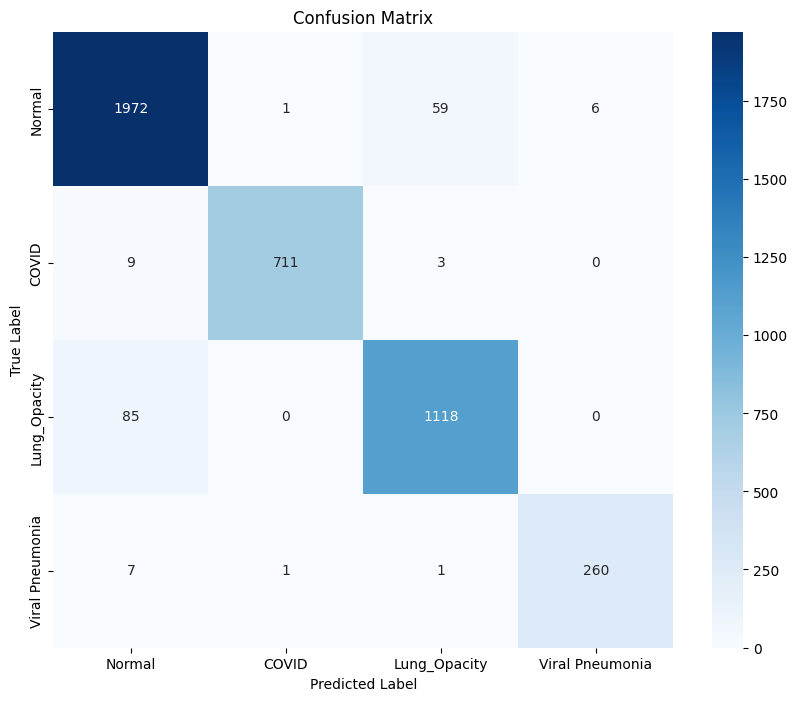


ROC Curves and AUC Scores


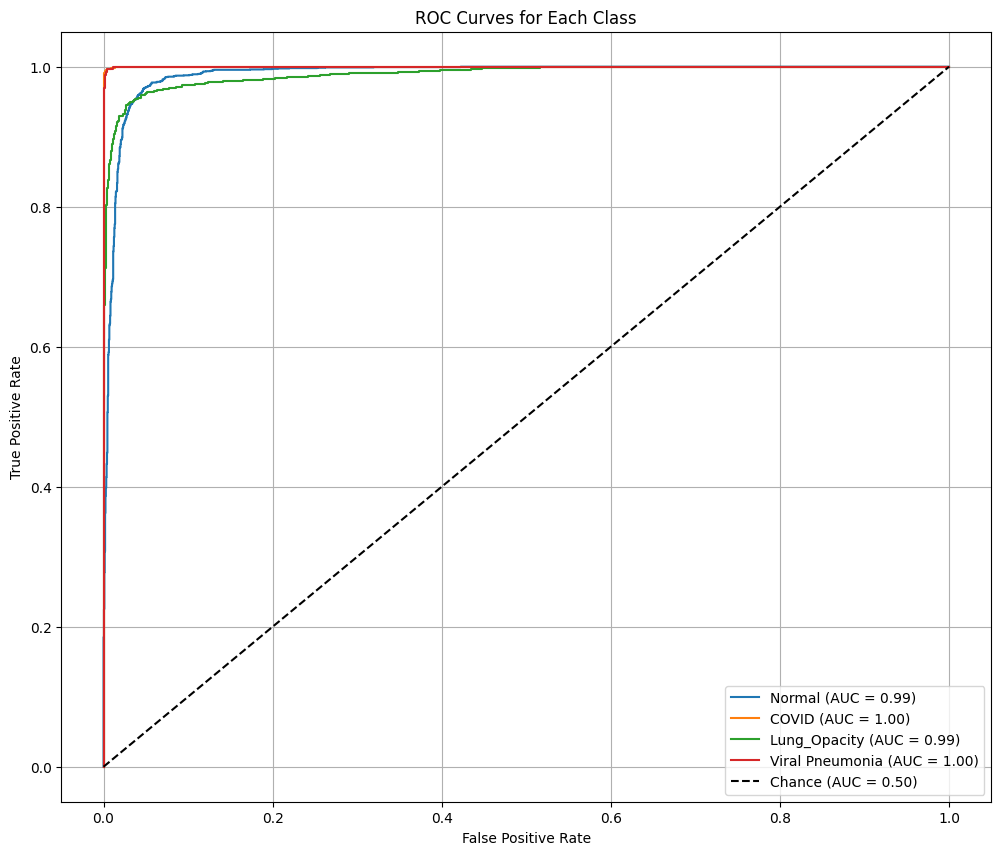

In [ ]:
# ==============================================================================
# CELL 4: EVALUATE THE CLASSIFICATION MODEL ON TEST DATA
# ==============================================================================
#@title 4. Load Best Model and Evaluate Performance

import torch
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# Ensure these variables are consistent with your training script
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
BATCH_SIZE = 32
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "classification_model.pth")
# DATA_DIR should already be defined from your previous cells

# --- Load Test Data ---
# First, let's prepare the full dataset again to create a test split
full_df = prepare_data(DATA_DIR)

# Split into train+validation (80%) and test (20%)
train_val_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df[CLASSES])

# Create the test dataset and dataloader
test_ds = ChestXRayDataset(test_df, get_transforms(train=False))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"✅ Test dataset created with {len(test_ds)} images.")

# --- Load the Best Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize the model architecture
model = models.densenet121()
model.classifier = nn.Linear(model.classifier.in_features, len(CLASSES))

# Load the saved weights from your best epoch
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.to(device)
model.eval() # Set model to evaluation mode
print(f"✅ Best model loaded from {MODEL_SAVE_PATH}")


# --- Get Predictions ---
all_labels = []
all_preds = []
all_pred_probs = []

print("⚙️ Running inference on test data...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Get prediction probabilities and predicted classes
        pred_probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (pred_probs > 0.5).astype(int)

        all_labels.extend(labels.numpy().astype(int))
        all_preds.extend(preds)
        all_pred_probs.extend(pred_probs)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_pred_probs = np.array(all_pred_probs)

# --- Display Results ---

# 1. Classification Report (Precision, Recall, F1-Score)
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=CLASSES, zero_division=0))

# 2. Confusion Matrix
print("\n" + "="*50)
print("Confusion Matrix")
print("="*50)
cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. ROC Curve and AUC for each class
print("\n" + "="*50)
print("ROC Curves and AUC Scores")
print("="*50)
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

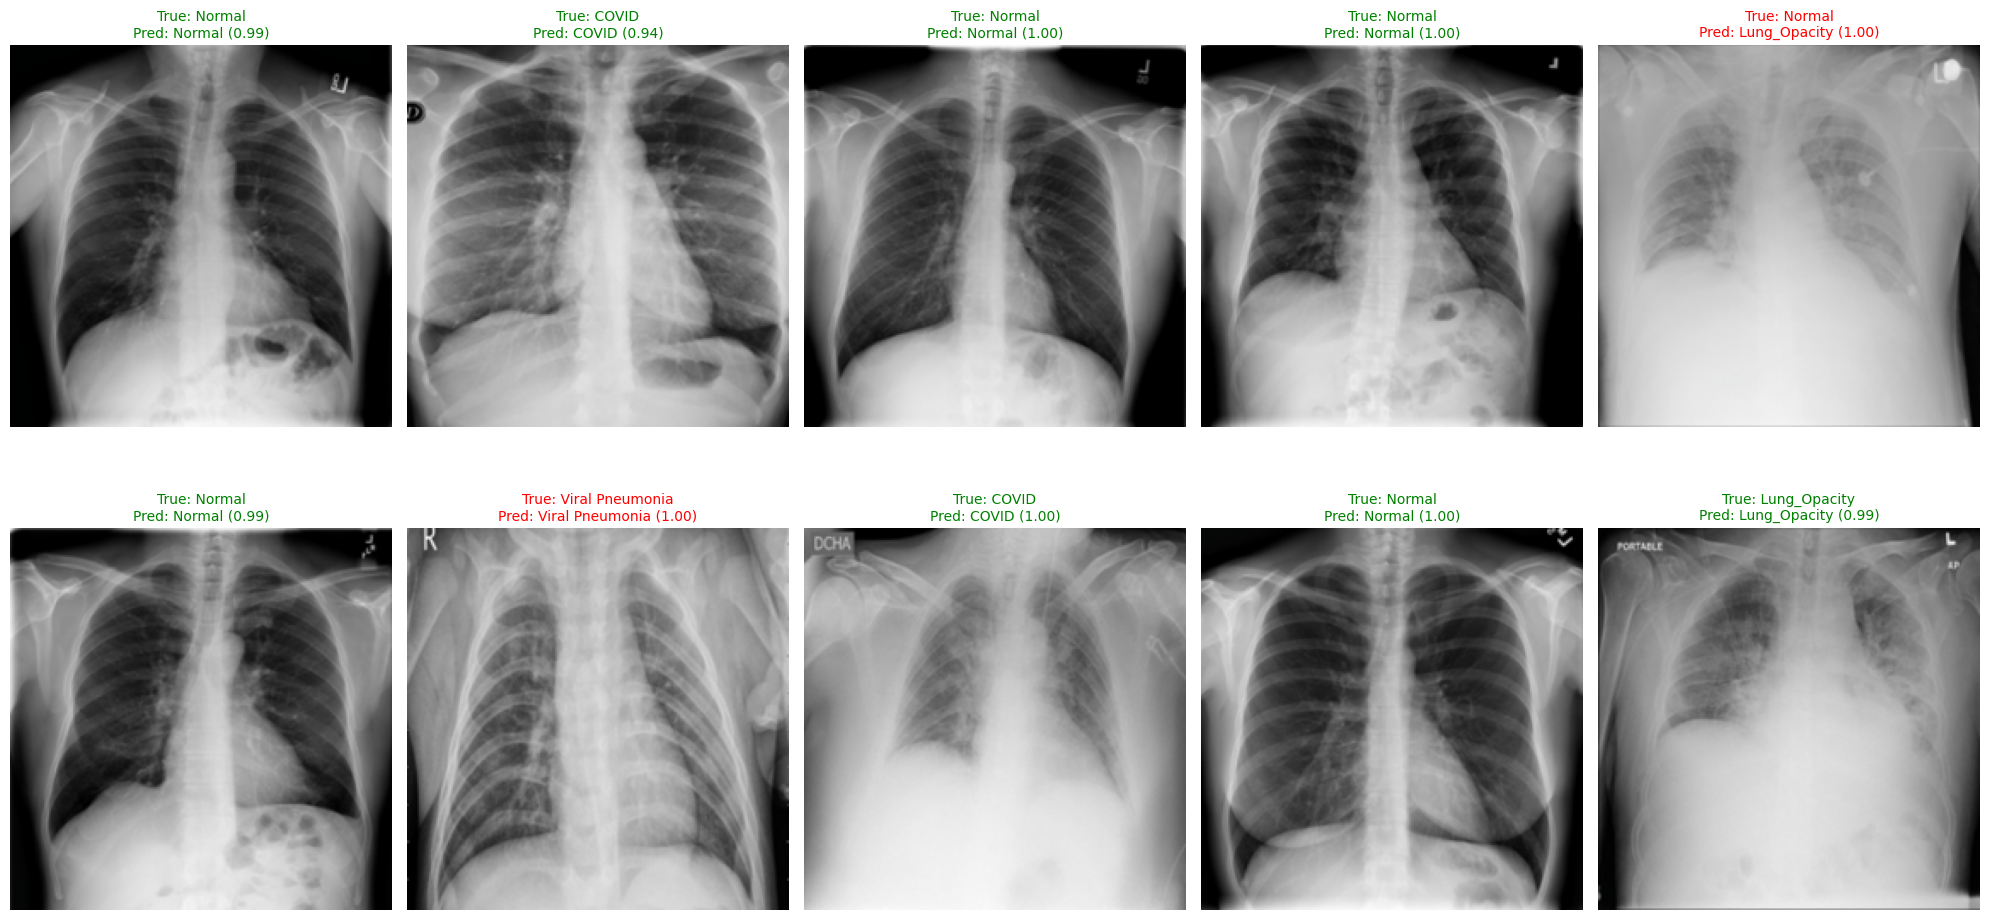

In [ ]:
# ==============================================================================
# CELL 5: VISUALLY COMPARE PREDICTIONS
# ==============================================================================
#@title 5. Visualize Original Images and Their Predictions

import matplotlib.pyplot as plt
import random

def visualize_predictions(dataset, model, device, num_images=10):
    """
    Displays a grid of images with their true and predicted labels.
    """
    plt.figure(figsize=(20, 15))
    model.eval() # Ensure model is in evaluation mode

    # Get random samples
    indices = random.sample(range(len(dataset)), k=num_images)

    for i, idx in enumerate(indices):
        # Get the sample from the dataset
        image_tensor, label_tensor = dataset[idx]
        true_labels = [CLASSES[j] for j, label in enumerate(label_tensor) if label == 1]

        # Get model prediction
        with torch.no_grad():
            # Add a batch dimension and send to device
            input_tensor = image_tensor.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_probs = torch.sigmoid(output).cpu().numpy()[0]

        predicted_labels = [f"{CLASSES[j]} ({pred_probs[j]:.2f})" for j, prob in enumerate(pred_probs) if prob > 0.5]

        # Prepare image for display (un-normalize)
        # Convert from Tensor (C, H, W) to NumPy (H, W, C)
        image_display = image_tensor.permute(1, 2, 0).numpy()
        # Un-normalize
        image_display = (image_display * np.array(STD)) + np.array(MEAN)
        image_display = np.clip(image_display, 0, 1) # Clip values to be between 0 and 1

        # Create subplot
        plt.subplot( (num_images // 5) + 1, 5, i + 1)
        plt.imshow(image_display)

        # Set title with true and predicted labels
        title_color = 'green' if sorted(true_labels) == sorted([p.split(' ')[0] for p in predicted_labels]) else 'red'
        plt.title(f"True: {', '.join(true_labels) or 'None'}\nPred: {', '.join(predicted_labels) or 'None'}", color=title_color, fontsize=10)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
# This assumes 'test_ds', 'model', and 'device' are already loaded from the previous cell
visualize_predictions(dataset=test_ds, model=model, device=device, num_images=10)

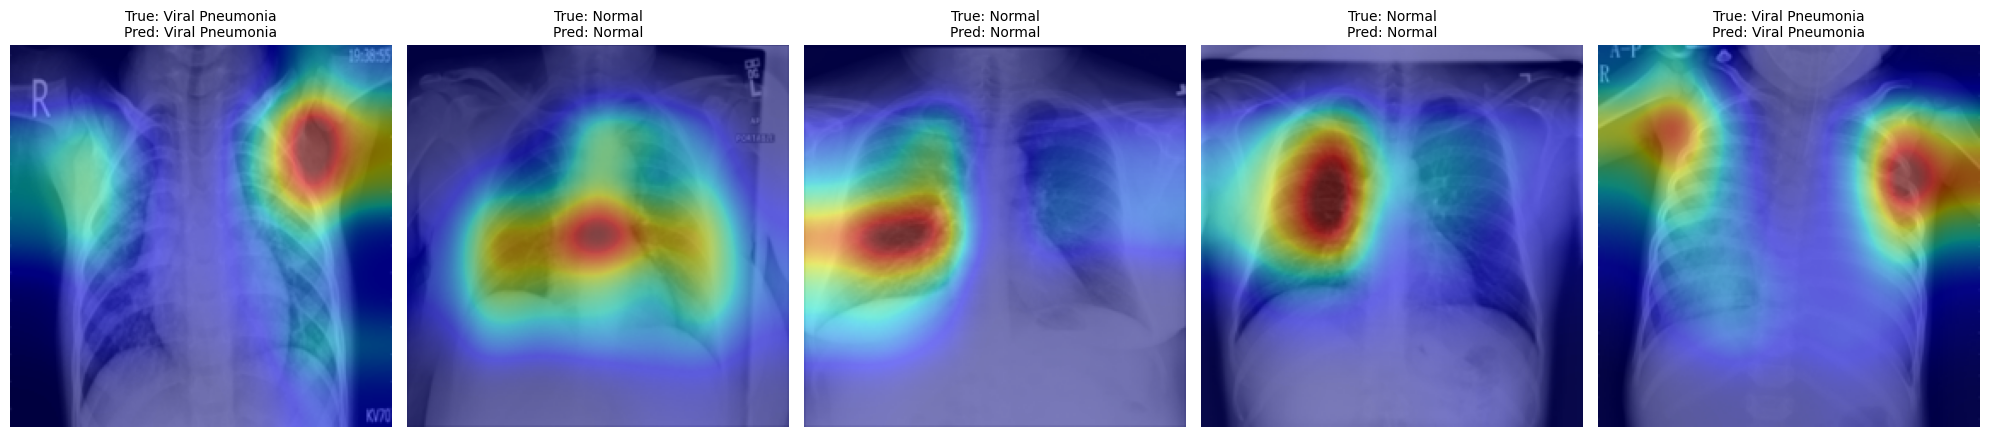

In [ ]:
# ==============================================================================
# CELL 6: GRAD-CAM VISUALIZATION (Corrected)
# ==============================================================================
#@title 6. Visualize Model's Attention with Grad-CAM

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import random

# Ensure model, test_ds, CLASSES, etc., are loaded from previous cells
model.eval()

# Set up the CAM extractor for DenseNet-121
cam_extractor = GradCAM(model, 'features.denseblock4.denselayer16.conv2')

def visualize_grad_cam(dataset, num_images=5):
    """
    Displays images with their Grad-CAM heatmaps.
    """
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(dataset)), k=num_images)

    for i, idx in enumerate(indices):
        image_tensor, label_tensor = dataset[idx]
        true_labels = [CLASSES[j] for j, label in enumerate(label_tensor) if label == 1]

        # --- FIX: The torch.no_grad() block has been removed here ---
        # We need gradients for Grad-CAM to work.
        output = model(image_tensor.unsqueeze(0).to(device))

        # Get the predicted class index
        pred_class_idx = output.argmax().item()

        # Generate the class activation map
        # The extractor will run a backward pass to get the gradients
        activation_map = cam_extractor(pred_class_idx, output)[0].cpu()

        # Un-normalize and prepare the original image for display
        image_display = image_tensor.permute(1, 2, 0).numpy()
        image_display = (image_display * np.array(STD)) + np.array(MEAN)
        image_display = np.clip(image_display, 0, 1)

        # Overlay the heatmap on the original image
        result = overlay_mask(to_pil_image(image_display), to_pil_image(activation_map, mode='F'), alpha=0.5)

        # Display the result
        plt.subplot(1, num_images, i + 1)
        plt.imshow(result)
        plt.title(f"True: {', '.join(true_labels)}\nPred: {CLASSES[pred_class_idx]}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    # Clear the hooks from the model layers
    cam_extractor.remove_hooks()


# Run the visualization
visualize_grad_cam(test_ds)

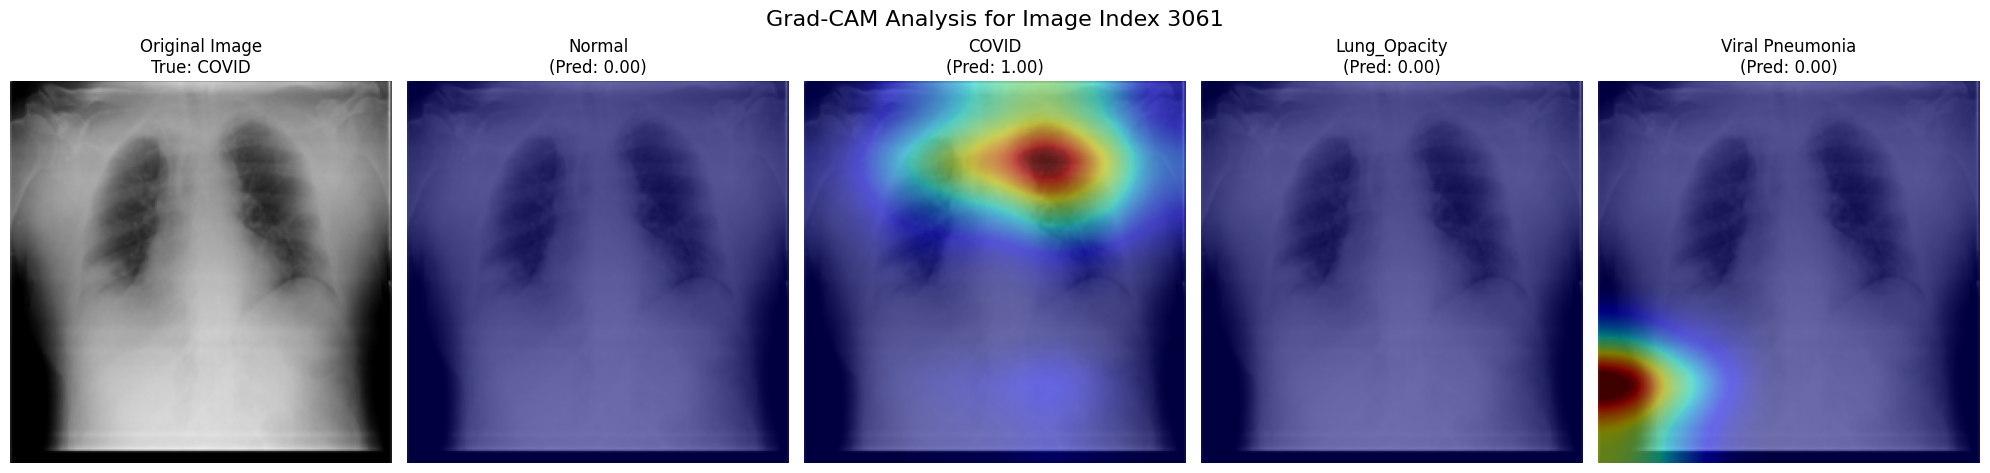

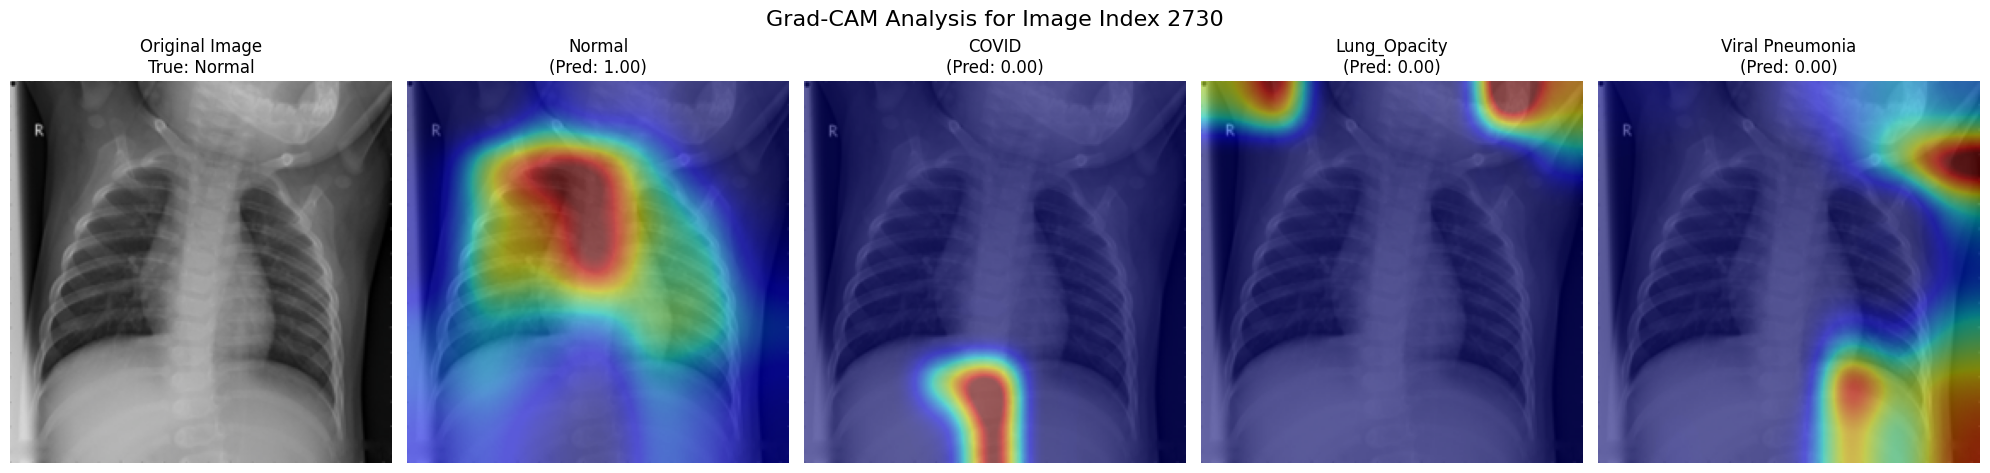

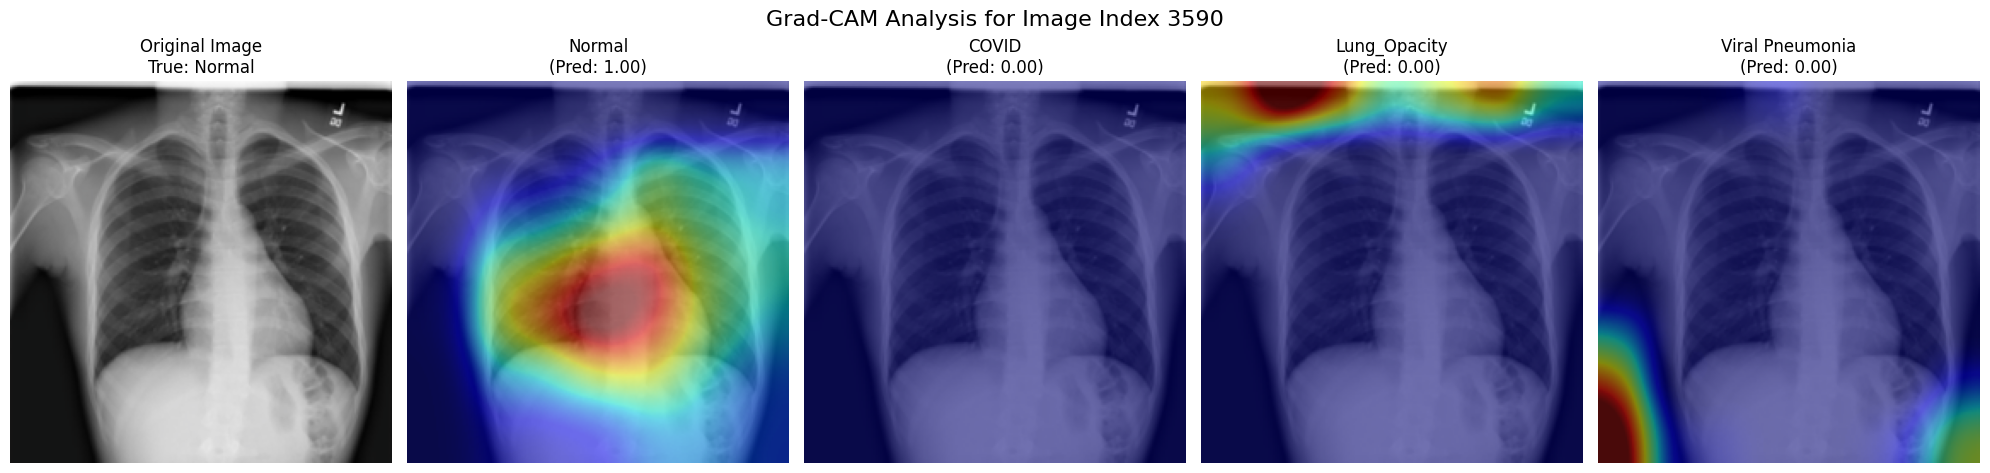

In [ ]:
# ==============================================================================
# CELL 6: GRAD-CAM VISUALIZATION FOR ALL CLASSES (Corrected)
# ==============================================================================
#@title 6. Visualize Model's Attention for All Classes

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import random
import torch.nn.functional as F

# Assume 'model', 'test_ds', 'CLASSES', etc., are loaded
model.eval()

# Set up the CAM extractor for DenseNet-121
cam_extractor = GradCAM(model, 'features.denseblock4.denselayer16.conv2')


def visualize_all_cams_for_image(dataset, model, device, num_images=3):
    """
    For a few sample images, displays the original image followed by
    a Grad-CAM heatmap for each possible class.
    """

    indices = random.sample(range(len(dataset)), k=num_images)

    for idx in indices:
        # Create a new figure for each image and its heatmaps
        plt.figure(figsize=(20, 5))

        image_tensor, label_tensor = dataset[idx]
        true_labels = [CLASSES[j] for j, label in enumerate(label_tensor) if label == 1]

        # --- Display Original Image ---
        image_display = image_tensor.permute(1, 2, 0).numpy()
        image_display = (image_display * np.array(STD)) + np.array(MEAN)
        image_display = np.clip(image_display, 0, 1)

        plt.subplot(1, len(CLASSES) + 1, 1)
        plt.imshow(image_display)
        plt.title(f"Original Image\nTrue: {', '.join(true_labels)}")
        plt.axis('off')

        # --- Loop through ALL classes to generate a heatmap for each ---
        for i, class_name in enumerate(CLASSES):
            # --- THE FIX IS HERE: The forward pass is now INSIDE the loop ---
            # This creates a fresh computational graph for each backward pass.
            output = model(image_tensor.unsqueeze(0).to(device))
            probs = F.sigmoid(output).data.squeeze().cpu().numpy()

            # Generate the class activation map for the current class index (i)
            activation_map = cam_extractor(class_idx=i, scores=output)[0].cpu()

            # Overlay the heatmap on the original image
            result = overlay_mask(to_pil_image(image_display), to_pil_image(activation_map, mode='F'), alpha=0.5)

            # Display the result in the next subplot
            plt.subplot(1, len(CLASSES) + 1, i + 2)
            plt.imshow(result)
            # Show the model's confidence for this specific class in the title
            plt.title(f"{class_name}\n(Pred: {probs[i]:.2f})")
            plt.axis('off')

        plt.suptitle(f"Grad-CAM Analysis for Image Index {idx}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Clear the hooks from the model layers
    cam_extractor.remove_hooks()


# Run the visualization for 3 random images
visualize_all_cams_for_image(test_ds, model, device, num_images=3)

⚙️ Loading a fresh instance of the best model...
✅ Fresh model loaded successfully.


Finding errors:   0%|          | 0/133 [00:00<?, ?it/s]


Displaying the 5 images the model was most wrong about:


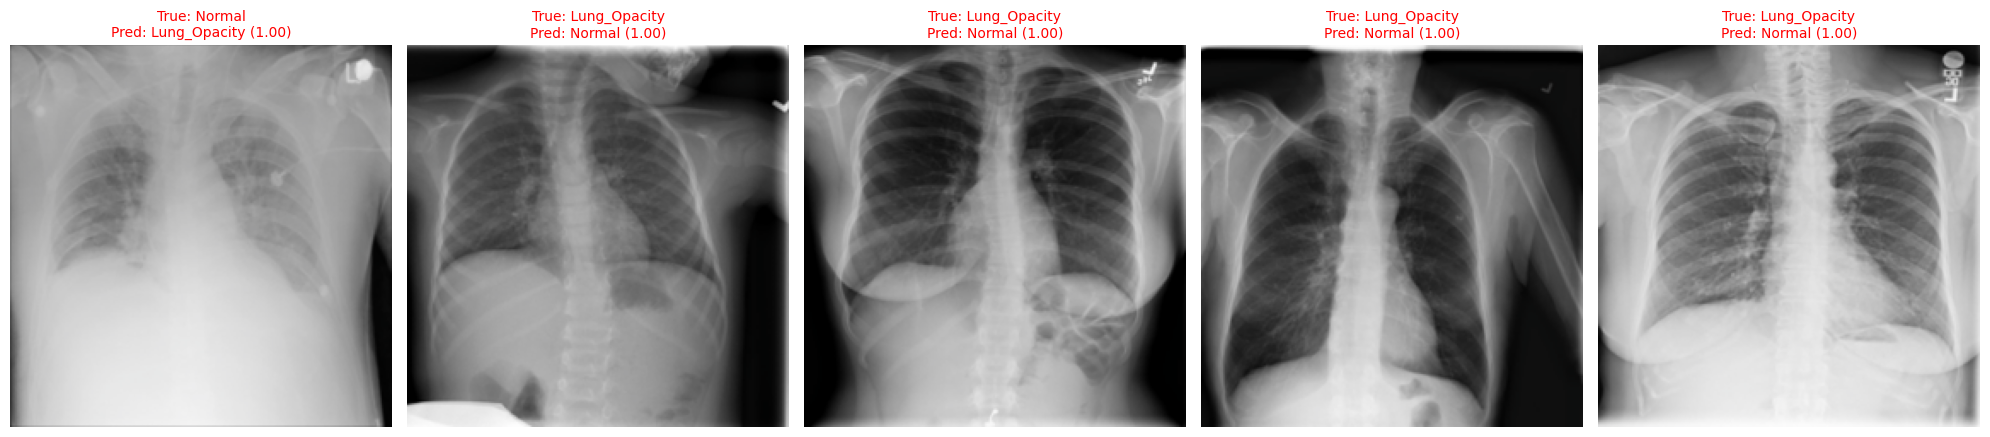

In [ ]:
# ==============================================================================
# CELL 7: DETAILED ERROR ANALYSIS (Final Version)
# ==============================================================================
#@title 7. Analyze Top Prediction Errors

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# --- THE FIX IS HERE: Load a fresh, clean instance of the model ---
print("⚙️ Loading a fresh instance of the best model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Re-initialize the model architecture
fresh_model = models.densenet121()
fresh_model.classifier = nn.Linear(fresh_model.classifier.in_features, len(CLASSES))

# 2. Load the saved weights from your best epoch
fresh_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
fresh_model.to(device)
fresh_model.eval() # Set to evaluation mode
print("✅ Fresh model loaded successfully.")
# --- End of Fix ---


losses = []
image_indices = []

# Calculate loss for every image in the test set using the FRESH model
for idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="Finding errors")):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = fresh_model(inputs) # Use fresh_model here
        # Calculate loss for each item in the batch
        batch_losses = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none').mean(dim=1)

        losses.extend(batch_losses.cpu().numpy())
        # Track the original indices
        start_idx = idx * test_loader.batch_size
        end_idx = start_idx + len(inputs)
        image_indices.extend(range(start_idx, end_idx))

# Get the indices of the top 5 most incorrect predictions
top_k_indices = np.argsort(losses)[-5:][::-1] # Top 5 highest losses

print("\nDisplaying the 5 images the model was most wrong about:")

# We use the visualization function defined in a previous cell
# but pass the fresh_model to it.
def visualize_predictions_with_indices(dataset, model_to_viz, device, custom_indices):
    """
    Displays a grid of specific images with their true and predicted labels.
    """
    num_images = len(custom_indices)
    plt.figure(figsize=(20, 5))
    model_to_viz.eval()

    for i, idx in enumerate(custom_indices):
        image_tensor, label_tensor = dataset[idx]
        true_labels = [CLASSES[j] for j, label in enumerate(label_tensor) if label == 1]

        with torch.no_grad():
            input_tensor = image_tensor.unsqueeze(0).to(device)
            output = model_to_viz(input_tensor)
            pred_probs = torch.sigmoid(output).cpu().numpy()[0]

        predicted_labels = [f"{CLASSES[j]} ({pred_probs[j]:.2f})" for j, prob in enumerate(pred_probs) if prob > 0.5]

        image_display = image_tensor.permute(1, 2, 0).numpy()
        image_display = (image_display * np.array(STD)) + np.array(MEAN)
        image_display = np.clip(image_display, 0, 1)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_display)

        title_color = 'red' # These are the top errors, so title is always red
        plt.title(f"True: {', '.join(true_labels) or 'None'}\nPred: {', '.join(predicted_labels) or 'None'}", color=title_color, fontsize=10)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the visualization function with the top error indices and the FRESH model
visualize_predictions_with_indices(dataset=test_ds, model_to_viz=fresh_model, device=device, custom_indices=top_k_indices)

In [ ]:
# ==============================================================================
# CELL 8: CALCULATE MEAN AVERAGE PRECISION (mAP)
# ==============================================================================
#@title 8. Calculate Mean Average Precision

from sklearn.metrics import average_precision_score

# 'all_labels' and 'all_pred_probs' should be available from Cell 4
average_precisions = []
print("--- Average Precision (AP) for Each Class ---")
for i, class_name in enumerate(CLASSES):
    ap = average_precision_score(all_labels[:, i], all_pred_probs[:, i])
    print(f"{class_name}: {ap:.4f}")
    average_precisions.append(ap)

mAP = np.mean(average_precisions)
print("\n" + "="*50)
print(f"Mean Average Precision (mAP): {mAP:.4f}")
print("="*50)

--- Average Precision (AP) for Each Class ---
Normal: 0.9864
COVID: 0.9997
Lung_Opacity: 0.9804
Viral Pneumonia: 0.9984

Mean Average Precision (mAP): 0.9912


--- Model Calibration Plots ---


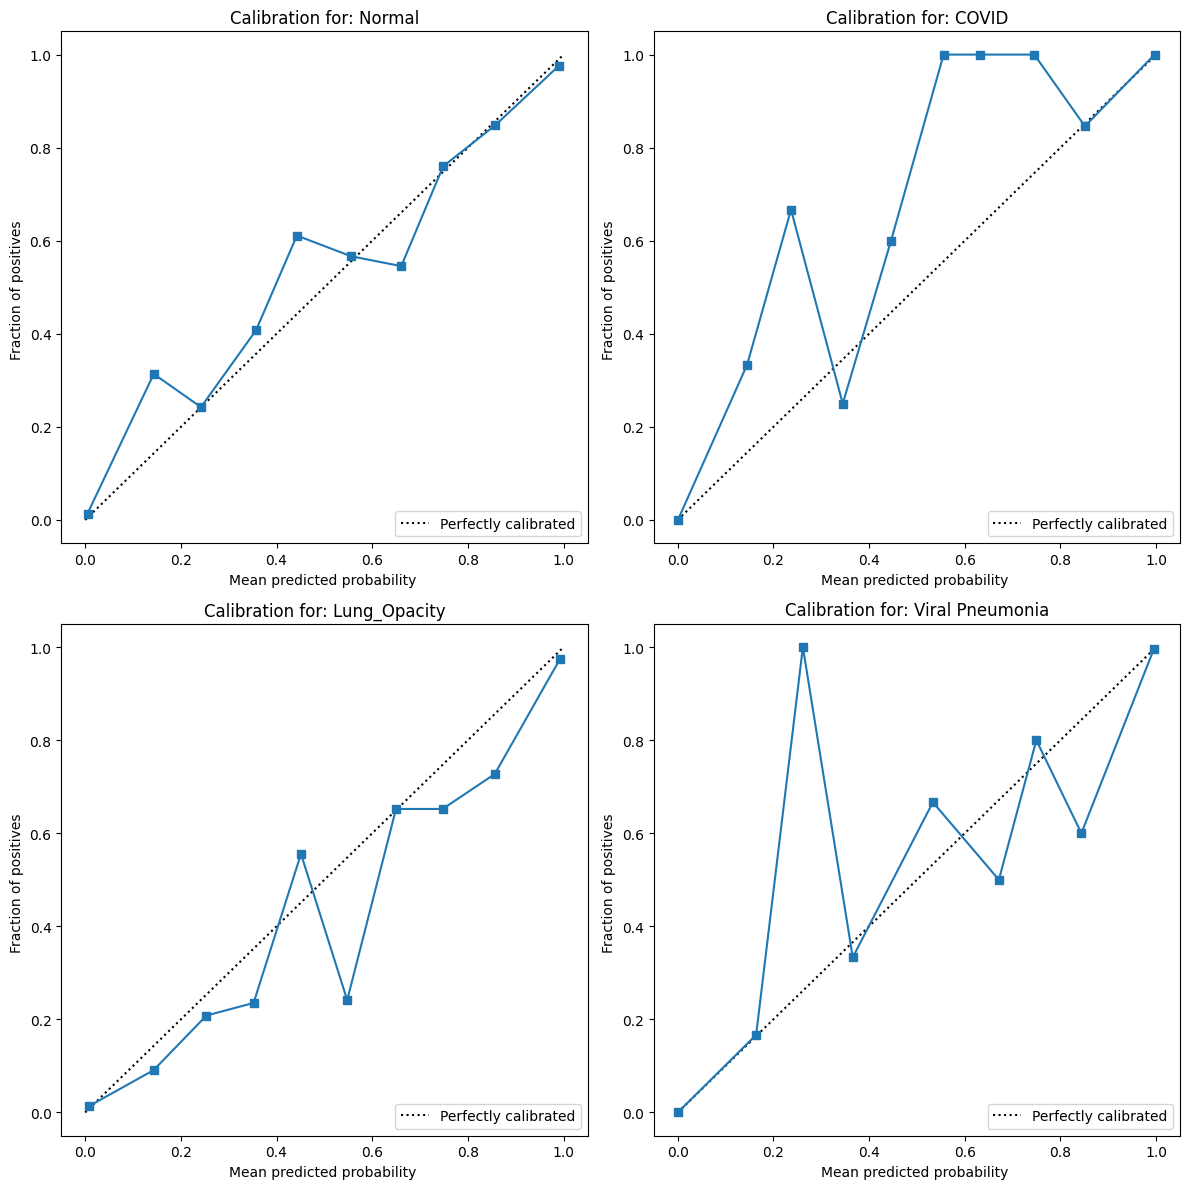

In [ ]:
# ==============================================================================
# CELL 9: CHECK MODEL CALIBRATION
# ==============================================================================
#@title 9. Create Calibration Plots

from sklearn.calibration import calibration_curve, CalibrationDisplay

print("--- Model Calibration Plots ---")
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i, class_name in enumerate(CLASSES):
    prob_true, prob_pred = calibration_curve(all_labels[:, i], all_pred_probs[:, i], n_bins=10, strategy='uniform')

    display = CalibrationDisplay(prob_true, prob_pred, all_pred_probs[:, i])
    display.plot(ax=axes[i])
    axes[i].set_title(f"Calibration for: {class_name}")

plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# CELL 10: CHECK COMPUTATIONAL PERFORMANCE
# ==============================================================================
#@title 10. Measure Model Size and Inference Time
import time

# --- 1. Model Size ---
model_size_bytes = os.path.getsize(MODEL_SAVE_PATH)
model_size_mb = model_size_bytes / (1024 * 1024)
print("--- Model Size ---")
print(f"The saved model size is: {model_size_mb:.2f} MB")


# --- 2. Inference Time ---
# Assume 'test_loader' and 'fresh_model' are loaded
dummy_input = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE).to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 100
timings = np.zeros((repetitions, 1))

# Warm-up GPU
for _ in range(10):
    _ = fresh_model(dummy_input)

# Measure
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = fresh_model(dummy_input)
        ender.record()
        # Wait for GPU sync
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

avg_latency_ms = np.sum(timings) / repetitions
throughput_fps = (BATCH_SIZE / (avg_latency_ms / 1000))

print("\n--- Inference Performance ---")
print(f"Average Batch Latency: {avg_latency_ms:.2f} ms")
print(f"Throughput: {throughput_fps:.2f} images/sec")

--- Model Size ---
The saved model size is: 27.13 MB

--- Inference Performance ---
Average Batch Latency: 93.58 ms
Throughput: 341.97 images/sec
